# CloudWalk Challenge — Anomaly Behavior Analysis (Task 3.1)

This notebook presents an exploratory analysis of hourly transaction data from two checkout points (`checkout_1.csv` and `checkout_2.csv`).  
The goal is to identify anomaly patterns by comparing today's sales volume with historical data: yesterday, same weekday last week, average of last week, and average of last month.


We will:
- Load the data
- Run some SQL queries using pandasql
- Visualize anomalies in sales trends


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Set visual style
sns.set(style="whitegrid")

# Load datasets
df1 = pd.read_csv('../data/checkout_1.csv')
df2 = pd.read_csv('../data/checkout_2.csv')

# Convert time column to numeric hour
df1['time'] = pd.to_datetime(df1['time'], format='%Hh').dt.hour
df2['time'] = pd.to_datetime(df2['time'], format='%Hh').dt.hour

## Visual Comparison of Hourly Sales

The following plots compare today's hourly sales with historical averages.  
This helps us visually detect unusual spikes or drops in transaction volume.

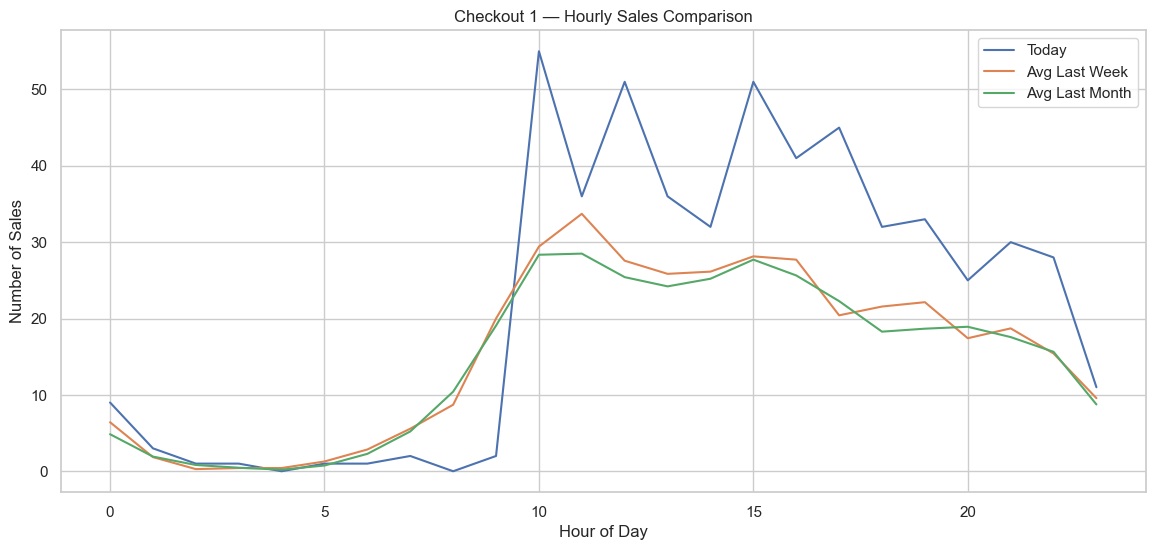

In [8]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df1, x='time', y='today', label='Today')
sns.lineplot(data=df1, x='time', y='avg_last_week', label='Avg Last Week')
sns.lineplot(data=df1, x='time', y='avg_last_month', label='Avg Last Month')
plt.title('Checkout 1 — Hourly Sales Comparison')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sales')
plt.legend()
plt.grid(True)
plt.show()

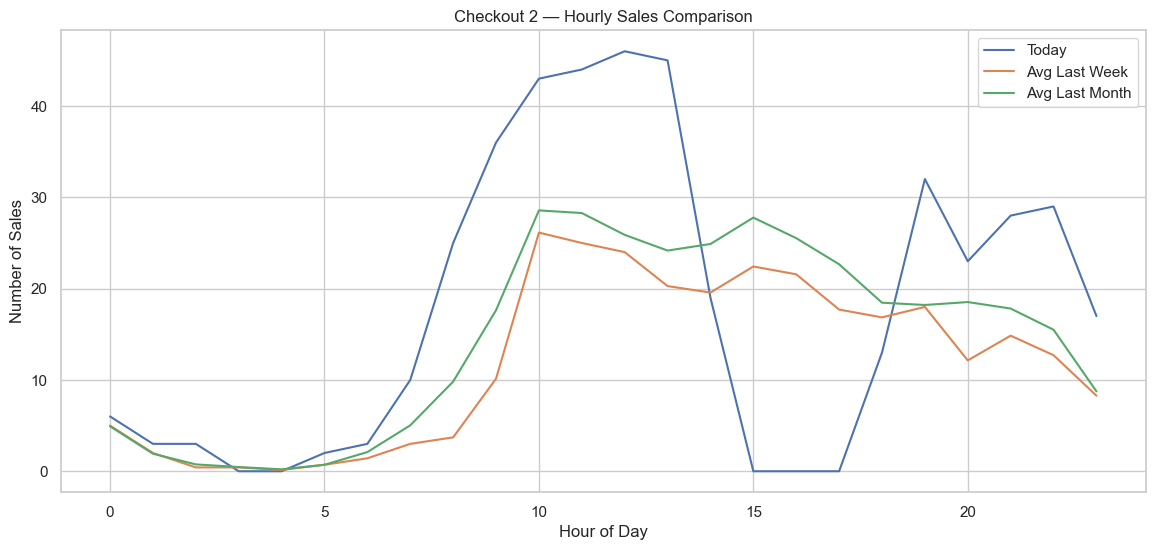

In [9]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df2, x='time', y='today', label='Today')
sns.lineplot(data=df2, x='time', y='avg_last_week', label='Avg Last Week')
sns.lineplot(data=df2, x='time', y='avg_last_month', label='Avg Last Month')
plt.title('Checkout 2 — Hourly Sales Comparison')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sales')
plt.legend()
plt.grid(True)
plt.show()

## Anomaly Detection Using Standard Deviation

We calculate the deviation between today's sales and historical averages.  
If the deviation exceeds two standard deviations, we flag it as a potential anomaly.

In [10]:
# Calculate deviation from historical averages
df1['deviation_week'] = df1['today'] - df1['avg_last_week']
df1['deviation_month'] = df1['today'] - df1['avg_last_month']

# Define thresholds (2 standard deviations)
threshold_week_1 = df1['deviation_week'].std() * 2
threshold_month_1 = df1['deviation_month'].std() * 2

# Flag anomalies
df1['anomaly_week'] = df1['deviation_week'].abs() > threshold_week_1
df1['anomaly_month'] = df1['deviation_month'].abs() > threshold_month_1

# Display anomalies
df1[df1['anomaly_week'] | df1['anomaly_month']]

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,deviation_week,deviation_month,anomaly_week,anomaly_month
10,10,55,51,45,29.42,28.35,25.58,26.65,True,True
12,12,51,39,39,27.57,25.42,23.43,25.58,True,True
15,15,51,35,49,28.14,27.71,22.86,23.29,True,True
17,17,45,30,29,20.42,22.28,24.58,22.72,True,True


In [11]:
df2['deviation_week'] = df2['today'] - df2['avg_last_week']
df2['deviation_month'] = df2['today'] - df2['avg_last_month']

threshold_week_2 = df2['deviation_week'].std() * 2
threshold_month_2 = df2['deviation_month'].std() * 2

df2['anomaly_week'] = df2['deviation_week'].abs() > threshold_week_2
df2['anomaly_month'] = df2['deviation_month'].abs() > threshold_month_2

df2[df2['anomaly_week'] | df2['anomaly_month']]

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,deviation_week,deviation_month,anomaly_week,anomaly_month
15,15,0,51,42,22.427,27.78,-22.427,-27.78,False,True


## SQL Query — Detecting High Deviations

To complement the analysis, we simulate a SQL query using SQLite to detect hours where today's transaction volume is more than twice the average of last week.

In [12]:
# Save DataFrames to SQLite in-memory database
conn = sqlite3.connect(':memory:')
df1.to_sql('checkout1', conn, index=False, if_exists='replace')
df2.to_sql('checkout2', conn, index=False, if_exists='replace')

# Define SQL query to find anomalies
query = """
SELECT time, today, yesterday, avg_last_week, avg_last_month
FROM checkout1
WHERE today > (avg_last_week * 2)
ORDER BY time;
"""

# Execute query and display results
sql_results = pd.read_sql(query, conn)
sql_results

,time,today,yesterday,avg_last_week,avg_last_month
0,2,1,0,0.28,0.82
1,3,1,0,0.42,0.46
2,17,45,30,20.42,22.28


## Summary of Findings

- **Checkout 1**: Unusual transaction spikes were observed at 10h, 12h, and 15h, exceeding historical baselines by more than 2 standard deviations. These patterns are consistent with either unauthorized batch processing or potential abuse of promotional mechanisms.

- **Checkout 2**: A complete drop in transaction volume between 15h and 17h indicates a critical failure in the checkout system. This behavior is incompatible with normal operational flow and should be treated as a high-severity incident.

### Security Implications

- The spikes in Checkout 1 may reflect automated or scripted transaction injections, which could be linked to fraud attempts or system misuse.
- The outage in Checkout 2 suggests a possible denial-of-service condition, system misconfiguration, or infrastructure failure affecting transaction integrity.
